Ссылка на Colab: https://colab.research.google.com/drive/12ZqueyraeLcg8sCLbVvE7all6b8cXBhz?usp=sharing

In [ ]:
# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Модуль pandas для обработки табличных данных
import pandas as pd

# работа с датами
from datetime import datetime as dt

# модели ML
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
# Загрузка датасета c Гугл Диска
gdown.download('https://drive.google.com/uc?id=1AjntkjOw1NPk0J-DzEl98W1Ex16v7Xrq', None, quiet=True)

'dosing_data.zip'

In [ ]:
# Распаковка архива в папку BashCardio
!unzip -qo dosing_data.zip -d BashCardio

# Просмотр содержимого папки (добавил в архив общий распаршенный датасет для сравнения данных)
!ls BashCardio

'Свод и чистка 8 больниц.xlsx'	 ЦАТ_NEFT.xlsx	 ЦАТ_общий_parsed.xlsx
 ЦАТ_BUZD.xlsx			 ЦАТ_OKT.xlsx	'Чишминская ЦРБ.xlsx'
 ЦАТ_GKB5.xlsx			 ЦАТ_SIB.xlsx
 ЦАТ_KMRT.xlsx			 ЦАТ_STR.xlsx


# Приведение датасетов к удобному виду для анализа

In [ ]:
# называем колонки просто цифрами (не придумал ничего оригинальнее)
COLUMN_NAMES = list(range(11))

In [ ]:
def apply_replacements(s, list_of_replacements):
  for replacement in list_of_replacements:
     s = s.replace(replacement[0], replacement[1])
  return s

def transform_gender(gender):
# преобразование пола: в результате 0 - женский пол, 1 - мужской
  gender_dict = {'мужской': 1, 'муж': 1, 'М': 1, 'м': 1, 'женский': 0, 'жен': 0, 'ж': 0, 'Ж': 0}

  return gender_dict[gender]

def transform_num(num):
# преобразование чисел (МНО) - приводим все к единому формату, переводим во float
  if type(num) is str:
    list_of_replacements = [('.,', '.'), (',,', '.'), (' , ', '.'), (' ,', '.'), (' .', '.'),
                            (', ', '.'),  (',', '.'), ('27.7время мно нет', '27.7')]

    num = apply_replacements(num, list_of_replacements)

  return float(num)

def transform_date(date):
# преобразование дат - приводим все к единому формату, переводим в datetime.datetime
  if date == '31.11.2022':
    date = '31.12.2022'

  try:
    if date[-1] == '.':
      date = date[:-1]
  except(IndexError):
    print('Ошибка индекса в дате', date=='')

  list_of_replacements = [('01.01.1971Хроническая  ревматическая болезнь сердца. Аортальный стеноз+недостаточность 2-3ст', '01.01.1971'),
                          ('021.11.2022', '21.11.2022'),
                          ('02.023.1949', '02.02.1949'),
                          ('26.12.212', '26.12.2022'), ('06.10.20212', '06.10.2022'),
                          ('ё', '04.01.2023'), ('17.01.23', '17.01.2023'), ('16.11.22.','16.11.2022'),
                          ('г.р.',''), ('г.р',''), ('г.',''), ('г',''), (',','.'),
                          ('.22','.2022'),
                          ('30.9.2022','30.09.2022'), ('29.062022','29.06.2022'),
                          ('14.112022','14.11.2022'), ('18.01.23', '18.01.2023'),
                          ('..', '.')]

  date = apply_replacements(date, list_of_replacements)

  return dt.strptime(date.strip(), '%d.%m.%Y')

def transform_age(date):
  if 'лет' in date or 'год' in date:
    list_of_replacements = [('года', ''), ('год', ''), ('лет', '')]

    return int(apply_replacements(date, list_of_replacements))

  else:
    birthdate = transform_date(date)

    return 2023 - birthdate.year

def load_data(fname, skiprows, col_shift=0):
# загрузка данных в DataFrame, параметры: fname - имя файла Excel с данными,
# skiprows - сколько строк пропускаем, col_shift - в одном из файлов необходимо
# сдвинуть номера колонок, здесь указываем, на какое число,
# возвращает: DataFrame с загруженными данными
  df = pd.read_excel(fname, names=COLUMN_NAMES, skiprows=skiprows)

  result = []
  rows = df.iterrows()
  num = 1
  for row in rows:

    # имя
    if type(row[1][1+col_shift]) is str:
      name = row[1][1+col_shift].strip()

    # пол
    if type(row[1][2+col_shift]) is str:
      try:
        gender = transform_gender(row[1][2+col_shift].strip())
      except(KeyError):
        print(fname, 'Error in gender!', row[1][2+col_shift])

    # дата рождения
    if type(row[1][3+col_shift]) is str and row[1][3+col_shift].strip() != '':
      try:
        age = transform_age(row[1][3+col_shift].strip())
      except(ValueError):
        print(fname, 'Error in birthdate!', row[1][3+col_shift])
    elif type(row[1][3+col_shift]) is dt:
      age = 2023 - row[1][3+col_shift].year

    # препарат
    if type(row[1][6+col_shift]) is str:
      medication = row[1][6+col_shift].strip()
    if type(row[1][8+col_shift]) is str:
      try:
        date = transform_date(row[1][8+col_shift])
      except(ValueError):
        print(fname, 'Error in date!', row[1][8+col_shift])
    else:
      date = row[1][8+col_shift]

    # доза
    try:
      value = transform_num(row[1][9+col_shift])
    except(ValueError, TypeError):
      print(fname, 'Error in value!', row[1][9+col_shift])
      value = float('nan')

    # некоторых пациентов обрабатываем вручную
    if name == 'Валеева Альфия Гафуровна':
      result.append([name, gender, age, dt.strptime('24.11.2022', '%d.%m.%Y'), 2.69])
      result.append([name, gender, age, dt.strptime('16.01.2023', '%d.%m.%Y'), 2.34])
    elif name == 'Александрова Валентина Михайловна' and row[1][8+col_shift] == '25.03.202':
      result.append([name, gender, age, dt.strptime('25.03.2022', '%d.%m.%Y'), 1.24])
    elif name == 'Акчурин Зинфар Зуфарович' and row[1][8+col_shift] == '18.10.202':
      result.append([name, gender, age, dt.strptime('18.10.2022', '%d.%m.%Y'), 1.98])
    elif name == 'Ямщикова Анна Михайловна' and row[1][8+col_shift] == '30.11.2022-2,36':
      result.append([name, gender, age, dt.strptime('30.11.2022', '%d.%m.%Y'), 2.36])
    elif name == 'Лобачева Надежда Романовна' and type(date) is not dt:
      result.append([name, gender, age, dt.strptime('01.11.2022', '%d.%m.%Y'), 2.94])

    # отсекаем только пациентов, принимающих варфарин
    elif 'варфарин' in medication.lower():
      result.append([name, gender, age, date, value])


  result = pd.DataFrame(result).dropna()
  counts = result[0].value_counts()
  result[9] = list(counts[result[0]])

  # отсекаем тех пациентов, которые встречаются более 1 раза
  return result[result[9] > 1][[0,1,2,3,4]]

# Проверка датасетов

Загружаем датасеты из исходных файлов и сводим все в один DataFrame. Выполняем сортировку сначала по имени пациента, потом по дате анализа (это важно, потому что определяет динамику МНО, в оригинальном датасете этого не было сделано, судя по всему).

In [ ]:
contents = [('/content/BashCardio/ЦАТ_BUZD.xlsx', 3, 0), ('/content/BashCardio/ЦАТ_GKB5.xlsx', 4, 0), ('/content/BashCardio/ЦАТ_KMRT.xlsx', 4, 0), ('/content/BashCardio/ЦАТ_NEFT.xlsx', 4, 0), ('/content/BashCardio/ЦАТ_OKT.xlsx', 4, 0), ('/content/BashCardio/ЦАТ_SIB.xlsx', 4, 0), ('/content/BashCardio/ЦАТ_STR.xlsx', 5, -1), ('/content/BashCardio/Чишминская ЦРБ.xlsx', 4, 0)]
dfs = []

for elem in contents:
  print(elem[0])
  df1 = load_data(elem[0], elem[1], elem[2])
  dfs.append(df1)

res = pd.concat(dfs)
res.sort_values(by=[0,3], inplace=True)

res.reset_index(drop=True)

/content/BashCardio/ЦАТ_BUZD.xlsx
/content/BashCardio/ЦАТ_BUZD.xlsx Error in date! 20.05.2022.г
/content/BashCardio/ЦАТ_GKB5.xlsx
/content/BashCardio/ЦАТ_KMRT.xlsx
/content/BashCardio/ЦАТ_KMRT.xlsx Error in date! 24.11.2022 г ., 16.01.2023г
/content/BashCardio/ЦАТ_KMRT.xlsx Error in value! 2,69    ., 2,34
/content/BashCardio/ЦАТ_NEFT.xlsx
/content/BashCardio/ЦАТ_OKT.xlsx
/content/BashCardio/ЦАТ_SIB.xlsx
/content/BashCardio/ЦАТ_STR.xlsx
/content/BashCardio/ЦАТ_STR.xlsx Error in date! 25.03.202
/content/BashCardio/ЦАТ_STR.xlsx Error in date! 18.10.202
/content/BashCardio/ЦАТ_STR.xlsx Error in value! 1944-03-01 00:00:00
/content/BashCardio/ЦАТ_STR.xlsx Error in date! 30.11.2022-2,36
/content/BashCardio/ЦАТ_STR.xlsx Error in value! 2023-08-01 00:00:00
/content/BashCardio/Чишминская ЦРБ.xlsx


,0,1,2,3,4
0,АБРАМОВ ТАТЬЯНА,0,76,2022-12-11,1.50
1,АБРАМОВ ТАТЬЯНА,0,76,2023-01-24,1.80
2,АГЕЕВ АНУВАР ГАБДУЛЛОВИЧ,1,76,2022-09-15,2.67
3,АГЕЕВ АНУВАР ГАБДУЛЛОВИЧ,1,76,2022-12-26,1.89
4,АГЕЕВ АНУВАР ГАБДУЛЛОВИЧ,1,76,2023-01-13,2.30
...,...,...,...,...,...
2565,мирзаянов Альфред Амирьянович,1,67,2023-01-13,3.00
2566,мирзаянов Альфред Амирьянович,1,67,2023-01-23,3.74
2567,тимофеев николай павлович,1,76,2022-12-21,2.00
2568,тимофеев николай павлович,1,76,2023-01-09,2.30


Для удобства переведем все в словарь, ключи - имена пациентов (в нижнем регистре, чтобы удобнее сравнивать), значения - списки МНО пациента, упорядоченные по дате измерения.

In [ ]:
res_dict = {}
name_index = 0
inr_index = 4

res_rows = res.iterrows()
for row in res_rows:
  name = row[1][name_index].lower()
  if name in res_dict:
    res_dict[name].append(row[1][inr_index])
  else:
    res_dict[name] = [row[1][inr_index]]

res_dict, len(res_dict)

({'абрамов татьяна': [1.5, 1.8],
  'агеев анувар габдуллович': [2.67, 1.89, 2.3],
  'ананьев владимир алексеевич': [2.4, 5.8, 2.8],
  'абдрахманов гаряй анварович': [3.41, 1.89, 1.59],
  'абдулганиева насима мазгаровна': [1.9, 2.9, 3.0],
  'абдулгафаров рафкат янузакович': [1.04, 1.67, 1.19],
  'абдулина миннигуль тажитдиновна': [1.53, 3.73, 3.17],
  'абдуллина надежда кирилловна': [2.0, 2.0],
  'абдульманов ильсур минигалеевич': [2.13, 2.11, 2.11, 2.89],
  'абзалов дамир мукадаевич': [2.9, 2.9, 2.6],
  'абзалова нафиса ахметсафиновна': [2.0, 2.0],
  'абросимова роза суфияновна': [1.0, 1.3],
  'абсалямова зугра г': [1.0, 1.0, 1.55],
  'абузарова гузяль шамилевна': [2.88, 3.12, 3.46],
  'абусев фаил рахимуллиевич': [2.29, 1.65, 1.97],
  'аверьянова ирина рафиковна': [1.7, 2.19, 2.2],
  'агафонова татьяна викторовна': [2.56, 2.34, 2.6],
  'агишев тагир фаритович': [2.3, 2.0],
  'аглиуллин филорит бодриевич': [2.5, 2.4, 2.1],
  'аглямова разида инсафовна': [1.36, 1.02, 1.01],
  'адельгаре

Получилось 865 пациентов. Теперь загрузим оригинальный датасет.

In [ ]:
df = pd.read_excel('/content/BashCardio/ЦАТ_общий_parsed.xlsx', sheet_name = [0,1])
df

{0:                     institution               id  gender   age   dose  \
 0     ГБУЗ РБ Толбазинская ЦРБ   140361892057136       0  57.0  7.500   
 1     ГБУЗ РБ Толбазинская ЦРБ   140361892057136       0  57.0  7.500   
 2     ГБУЗ РБ Толбазинская ЦРБ   140361892057264       1  50.0  5.000   
 3     ГБУЗ РБ Толбазинская ЦРБ   140361892057392       0  53.0  6.250   
 4     ГБУЗ РБ Толбазинская ЦРБ   140361892057392       0  53.0  6.250   
 ...                         ...              ...     ...   ...    ...   
 1463     ГБУЗ РБ Янаульская ЦРБ  139766010360000       1  68.0  3.750   
 1464     ГБУЗ РБ Янаульская ЦРБ  139766010360144       1  35.0  3.750   
 1465     ГБУЗ РБ Янаульская ЦРБ  139766010360144       1  35.0  3.750   
 1466     ГБУЗ РБ Янаульская ЦРБ  139766010360288       0  64.0  2.500   
 1467     ГБУЗ РБ Янаульская ЦРБ  139766010360288       0  64.0  1.875   
 
      date_analyse  prev_INR(MHO)  atrial_fibrillation  mitral_valve  \
 0      2022-11-11           3.11  

Соединим со вторым листом, чтобы получить ФИО пациентов (а не только id).

In [ ]:
persons_final = df[0][['id', 'prev_INR(MHO)', 'INR(MHO)', 'institution']].merge(df[1][['id','FIO']], how='left', on='id')
persons_final

,id,prev_INR(MHO),INR(MHO),institution,FIO
0,140361892057136,3.11,3.32,ГБУЗ РБ Толбазинская ЦРБ,Гайнуллин ильшат Раисович
1,140361892057136,3.32,2.01,ГБУЗ РБ Толбазинская ЦРБ,Гайнуллин ильшат Раисович
2,140361892057264,2.01,2.75,ГБУЗ РБ Толбазинская ЦРБ,Алпарова Гульнара Раиловна
3,140361892057392,1.42,2.56,ГБУЗ РБ Толбазинская ЦРБ,Ашмарин Андрей Петрович
4,140361892057392,2.56,2.80,ГБУЗ РБ Толбазинская ЦРБ,Ашмарин Андрей Петрович
...,...,...,...,...,...
1463,139766010360000,1.34,2.30,ГБУЗ РБ Янаульская ЦРБ,Петрова Земфира Вениаминовна
1464,139766010360144,1.50,1.04,ГБУЗ РБ Янаульская ЦРБ,Кутлиахметова Анна Валериевна
1465,139766010360144,1.04,1.03,ГБУЗ РБ Янаульская ЦРБ,Кутлиахметова Анна Валериевна
1466,139766010360288,2.80,3.19,ГБУЗ РБ Янаульская ЦРБ,Шайгадамов Каримьян Шаймухаметович


Проделаем те же действия по переводу в словарь.

In [ ]:
orig_dict = {}

orig_rows = persons_final.iterrows()
for row in orig_rows:
  name = row[1]['FIO'].lower().replace('\xa0', '').strip()
  if name in orig_dict:
    orig_dict[name].append(row[1]['INR(MHO)'])
  else:
    orig_dict[name] = [row[1]['prev_INR(MHO)'], row[1]['INR(MHO)']]

orig_dict, len(orig_dict)

({'гайнуллин ильшат раисович': [3.11, 3.32, 2.01],
  'алпарова гульнара раиловна': [2.01, 2.75],
  'ашмарин андрей петрович': [1.42, 2.56, 2.8],
  'кутлияров ринат рашитович': [2.16, 2.1],
  'рамаданова раиса николаевна': [2.6, 2.1],
  'галеев фанур гизитдинович': [1.5, 3.2],
  'забелин иван петрович': [2.8, 1.98],
  'воробьева ольга васильевна': [1.41, 1.99, 3.16],
  'горина аниса латыповна': [2.18, 2.29, 4.09],
  'логвин сергей лукьянович': [1.58, 1.81, 2.51],
  'волкова надежда петровна': [1.23, 2.11, 2.47],
  'акчурин зинфар зуфарович': [2.7, 1.98, 1.73],
  'аглямова разида инсафовна': [1.02, 1.36, 1.01],
  'назаров рафис шарифьянович': [1.0, 1.95, 1.08],
  'новиков а. в.': [1.63, 2.58, 2.7],
  'уманцева е. с.': [2.02, 2.3, 2.58],
  'битунов виктор петрович': [1.18, 1.18, 1.18],
  'зайнетдинович валеев радик': [1.72, 1.09, 1.2],
  'андреев анатолий иванович': [2.15, 2.72, 2.48],
  'халиков руслан филусович': [2.08, 2.1],
  'сафиуллина минигайша зайнетдиновна': [3.07, 3.28, 2.48],
 

Получилось 767 человек, то есть на 98 меньше! Теперь сравним порядок значений МНО.

In [ ]:
count = 0
for person in res_dict:
  if person in orig_dict:
    if res_dict[person] == orig_dict[person]:
      continue
    else:
      count += 1
      print('В датасете нарушена последовательность измерений для', person, '- в оригинале было', res_dict[person], 'стало', orig_dict[person])
  else:
      print('Не найден ключ', person, 'в датасете')

print ('Нарушена последовательность для', count, 'пациентов')

В датасете нарушена последовательность измерений для агеев анувар габдуллович - в оригинале было [2.3, 1.89, 2.67] стало [2.67, 1.89, 2.3]
Не найден ключ абдулгафаров рафкат янузакович в датасете
В датасете нарушена последовательность измерений для абдулина миннигуль тажитдиновна - в оригинале было [3.73, 3.17, 1.53] стало [1.53, 3.73, 3.17]
В датасете нарушена последовательность измерений для абузарова гузяль шамилевна - в оригинале было [3.46, 3.12, 2.88] стало [2.88, 3.12, 3.46]
В датасете нарушена последовательность измерений для абусев фаил рахимуллиевич - в оригинале было [1.65, 1.97, 2.29] стало [2.29, 1.65, 1.97]
Не найден ключ аверьянова ирина рафиковна в датасете
В датасете нарушена последовательность измерений для аккужина минира хатмулловна - в оригинале было [2.62, 2.2, 3.85] стало [3.85, 2.2, 2.62]
Не найден ключ александров владимир анатольевич в датасете
Не найден ключ алетдинов фавазит фаваритович в датасете
В датасете нарушена последовательность измерений для аллагуло

Могут быть небольшие неточности, но пока есть ощущение, что из 865 пациентов, которые я вытащил, в датасете присутствуют только 767, из которых у 135 нарушена последовательность взятия показателя МНО (то есть регрессия будет неверно считаться на них). Поэтому в датасете есть еще над чем поработать.

# Подгрузка данных доз и диагнозов и преобразование данных

In [ ]:
df = pd.read_excel('/content/BashCardio/Свод и чистка 8 больниц.xlsx', sheet_name = 1)
df

,Name,patient,gender,age,diagnos,sss,mg,AnalisDate,MNO,ИндексДиаг,ИндексПац,ИндексSSS
0,ЦАТ_SIBа.xlsx,Абдрахимов Гайфулла Рахимьянович,0,64.31759,ИБС,0,2.500,2022-11-28,2.46,3,484,1
1,ЦАТ_KMRTа.xlsx,Абдрахманов Гаряй Анварович,0,65.38261,ИБС ПС,ПК,7.500,2022-09-16,3.41,8,135,3
2,ЦАТ_KMRTа.xlsx,Абдрахманов Гаряй Анварович,0,65.38261,ПС,ПК,8.125,2022-11-02,1.89,2,135,3
3,ЦАТ_KMRTа.xlsx,Абдрахманов Гаряй Анварович,0,65.38261,ПС,ПК,8.125,2022-12-28,1.59,2,135,3
4,ЦАТ_KMRTа.xlsx,Абдрахманова Минигуль Габдуловна,1,69.91102,ПС,ПК,8.125,2022-03-23,2.87,2,136,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1912,ЦАТ_GKB5а.xlsx,Яхин Махмут Шарифуллович,0,76.47912,ФП,0,2.500,2022-12-21,2.43,1,73,1
1913,ЦАТ_GKB5а.xlsx,Яхин Махмут Шарифуллович,0,76.47912,ФП,0,2.500,2023-12-19,2.16,1,73,1
1914,ЦАТ_SIBа.xlsx,Яценко Людмила Афанасьевна,1,81.90007,ФП,0,2.500,2022-12-28,1.14,1,485,1
1915,ЦАТ_SIBа.xlsx,Яценко Людмила Афанасьевна,1,81.90007,ФП,0,2.500,2023-01-24,2.87,1,485,1


In [ ]:
res.rename(columns = {0: 'patient', 3: 'AnalisDate'}, inplace = True )

df_parsed = res.merge(df, how='left', on=['patient', 'AnalisDate']).dropna()[['patient', 1, 2, 'ИндексДиаг', 'ИндексSSS', 'mg', 'AnalisDate', 'MNO']]
df_parsed.rename(columns = {1: 'gender', 2: 'age', 'ИндексДиаг': 'diagnosis', 'ИндексSSS': 'events', 'MNO': 'INR'}, inplace = True )
df_parsed

,patient,gender,age,diagnosis,events,mg,AnalisDate,INR
0,АБРАМОВ ТАТЬЯНА,0,76,1.0,1.0,2.500,2022-12-11,1.50
1,АБРАМОВ ТАТЬЯНА,0,76,1.0,1.0,2.500,2023-01-24,1.80
2,АГЕЕВ АНУВАР ГАБДУЛЛОВИЧ,1,76,1.0,1.0,4.375,2022-09-15,2.67
3,АГЕЕВ АНУВАР ГАБДУЛЛОВИЧ,1,76,1.0,1.0,4.375,2022-12-26,1.89
4,АГЕЕВ АНУВАР ГАБДУЛЛОВИЧ,1,76,1.0,1.0,4.375,2023-01-13,2.30
...,...,...,...,...,...,...,...,...
2567,каюмов Флюз Вазирович,1,56,2.0,1.0,6.250,2023-01-09,2.30
2568,каюмов Флюз Вазирович,1,56,2.0,1.0,6.250,2023-01-20,2.50
2569,мирзаянов Альфред Амирьянович,1,67,2.0,1.0,5.000,2022-12-09,4.36
2570,мирзаянов Альфред Амирьянович,1,67,2.0,1.0,5.000,2023-01-13,3.00


## Аугментация данных и обогащение признаков

Первая гипотеза для аугментации - интерполировать данные МНО по дням, чтобы оперировать одинаковыми интервалами. Для начала попробуем обычную линейную интерполяцию.

In [ ]:
from numpy import interp

from matplotlib.pyplot import plot

In [ ]:
xp = [0, 7, 18]
yp = [2.4, 5.8, 2.8]

x = list(range(19))

interp(x, xp, yp)

array([2.4       , 2.88571429, 3.37142857, 3.85714286, 4.34285714,
       4.82857143, 5.31428571, 5.8       , 5.52727273, 5.25454545,
       4.98181818, 4.70909091, 4.43636364, 4.16363636, 3.89090909,
       3.61818182, 3.34545455, 3.07272727, 2.8       ])

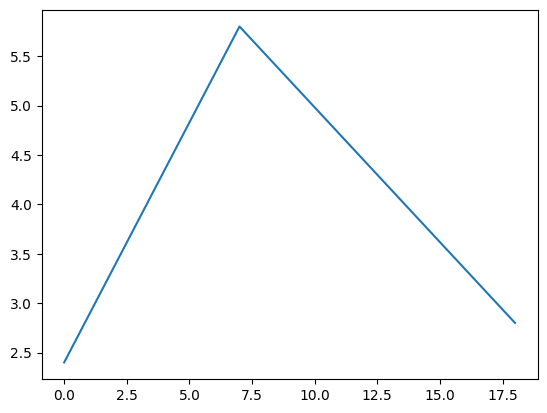

In [ ]:
plot(x, interp(x, xp, yp))

Предлагается следующая идея для добавления нового признака: разбить пациентов по классам чувствительности на препарат - для этого посмотреть, как одинаковые дозы влияют на разных людей.

In [ ]:
# порог для отсечения тренда (какое изменение МНО мы не считаем существенным при определении тренда),
# чем он больше, тем меньше данных будет отсеиваться, как противоречивые
TREND_THRESHOLD = 0.5

# порог для количества прошедших дней (если между измерениями прошло дней больше, убираем строку)
DAYS_THRESHOLD = 60

def transform_data(df):

  result = []
  rows = df.iterrows()
  num = 0
  delta = 0
  # здесь будет список пациентов, которых удалим из итогового списка (с противоречивыми данными)
  remove_patients = []
  trends = {}

  for row in rows:

    if num > 0:
      if result[num-1][0] == row[1]['patient']:
        result[num-1].append((row[1]['AnalisDate'] - prev_date).days)
        result[num-1].append(row[1]['INR'])
        new_trend = 0 if abs(result[num-1][6] - result[num-1][8]) <= TREND_THRESHOLD else int((result[num-1][8] - result[num-1][6]) /  abs(result[num-1][8] - result[num-1][6]))
        #print('Пациент', result[num-1][0], ' - добавлен тренд', new_trend, 'для дозировки', result[num-1][5], '(изменение МНО с', result[num-1][6], '(', prev_date, ') до', result[num-1][8], '(', row[1]['AnalisDate'], ')')
        if result[num-1][5] in trends:
          trends[result[num-1][5]].append(new_trend)
          if -1 in trends[result[num-1][5]] and 1 in trends[result[num-1][5]] and not result[num-1][0] in remove_patients:
            remove_patients.append(result[num-1][0])
            #print('Удален пациент', result[num-1][0], ' из-за противоречий в данных МНО.')
        else:
          trends[result[num-1][5]] = [new_trend]
      else:
        trends = {}
        result.pop(-1)
        num -= 1


    result.append([row[1]['patient'], row[1]['gender'], row[1]['age'], row[1]['diagnosis'], row[1]['events'], row[1]['mg'], row[1]['INR']])
    prev_date = row[1]['AnalisDate']

    num += 1

  result.pop(-1)

  # закомментировать эту часть, если не нужно удалять данные из списка
  for elem in result[::-1]:
   if elem[0] in remove_patients or elem[7] > DAYS_THRESHOLD:
     result.remove(elem)

  # аугментация данных
  # result_aug = []
  # for elem in result[:350]:
  #   inr_interp = interp(list(range(elem[7])), [0, elem[7]], [elem[6], elem[8]])
  #   for x, y in enumerate(inr_interp):
  #     result_aug.append(elem.copy())
  #     result_aug[-1][6] = round(y, 2)
  #     result_aug[-1][7] = 1
  #     if x > 0:
  #       result_aug[-2][8] = round(y, 2)

  print(result)

  for elem in result:
    inr_interp = interp(list(range(elem[7])), [0, elem[7]], [elem[6], elem[8]])
    if len(inr_interp) > 1:
      elem[7] = 1
      elem[8] = inr_interp[1]

  print(result)

  return pd.DataFrame(result, columns = ['patient', 'gender', 'age', 'diagnosis', 'events', 'dose', 'INR1', 'days_pass', 'INR2'])

In [ ]:
data_transformed = transform_data(df_parsed)

[['АБРАМОВ ТАТЬЯНА', 0, 76, 1.0, 1.0, 2.5, 1.5, 44, 1.8], ['АГЕЕВ АНУВАР ГАБДУЛЛОВИЧ', 1, 76, 1.0, 1.0, 4.375, 1.89, 18, 2.3], ['Абдрахманов Гаряй Анварович', 1, 66, 8.0, 3.0, 7.5, 3.41, 47, 1.89], ['Абдрахманов Гаряй Анварович', 1, 66, 2.0, 3.0, 8.125, 1.89, 56, 1.59], ['Абдулганиева Насима Мазгаровна', 0, 66, 2.0, 1.0, 5.0, 2.9, 58, 3.0], ['Абдуллина Надежда Кирилловна', 0, 77, 1.0, 1.0, 3.75, 2.0, 34, 2.0], ['Абдульманов Ильсур Минигалеевич', 1, 61, 2.0, 3.0, 3.75, 2.13, 5, 2.11], ['Абдульманов Ильсур Минигалеевич', 1, 61, 2.0, 3.0, 3.75, 2.11, 1, 2.11], ['Абдульманов Ильсур Минигалеевич', 1, 61, 2.0, 3.0, 3.75, 2.11, 30, 2.89], ['Абзалова Нафиса Ахметсафиновна', 0, 65, 1.0, 1.0, 2.5, 2.0, 34, 2.0], ['Абросимова Роза Суфияновна', 0, 69, 1.0, 1.0, 3.75, 1.0, 54, 1.3], ['Абузарова Гузяль Шамилевна', 0, 63, 1.0, 1.0, 5.0, 2.88, 22, 3.12], ['Абузарова Гузяль Шамилевна', 0, 63, 1.0, 1.0, 5.0, 3.12, 47, 3.46], ['Аверьянова Ирина Рафиковна', 0, 63, 2.0, 3.0, 2.5, 1.7, 33, 2.19], ['Аверьяно

In [ ]:
print(data_transformed)
len(data_transformed)

                            patient  gender  age  diagnosis  events   dose  \
0                   АБРАМОВ ТАТЬЯНА       0   76        1.0     1.0  2.500   
1          АГЕЕВ АНУВАР ГАБДУЛЛОВИЧ       1   76        1.0     1.0  4.375   
2       Абдрахманов Гаряй Анварович       1   66        8.0     3.0  7.500   
3       Абдрахманов Гаряй Анварович       1   66        2.0     3.0  8.125   
4    Абдулганиева Насима Мазгаровна       0   66        2.0     1.0  5.000   
..                              ...     ...  ...        ...     ...    ...   
646      Яценко Людмила Афанасьевна       0   82        1.0     1.0  2.500   
647     гатиятуллин вагиз ахметович       1   60        1.0     1.0  2.500   
648     гатиятуллин вагиз ахметович       1   60        1.0     1.0  2.500   
649           каюмов Флюз Вазирович       1   56        2.0     1.0  6.250   
650           каюмов Флюз Вазирович       1   56        2.0     1.0  6.250   

     INR1  days_pass      INR2  
0    1.50          1  1.506818

651

# Обучение моделей

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data_transformed[['gender', 'age', 'diagnosis', 'events', 'dose', 'INR1']],
    data_transformed[['INR2']], test_size=0.1, random_state=13)

params = {
    "n_estimators": 500,
    "max_depth": 3,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [ ]:
X_test, y_test

(     gender  age  diagnosis  events   dose  INR1
 188       1   81        7.0     3.0  3.125  1.00
 179       0   82        1.0     1.0  3.125  1.67
 99        0   74        1.0     1.0  7.500  1.61
 140       1   71        1.0     1.0  2.500  2.10
 37        1   66        1.0     1.0  2.500  1.70
 ..      ...  ...        ...     ...    ...   ...
 512       1   76        1.0     1.0  2.500  2.70
 357       0   70        1.0     1.0  5.000  1.00
 29        1   55        1.0     1.0  3.750  1.60
 352       1   64        1.0     1.0  5.000  2.88
 440       0   69        1.0     1.0  3.750  1.16
 
 [66 rows x 6 columns],
          INR2
 188  1.022581
 179  1.680909
 99   1.594091
 140  2.110256
 37   1.705172
 ..        ...
 512  2.675000
 357  1.005882
 29   1.620000
 352  2.848571
 440  1.163214
 
 [66 rows x 1 columns])

In [ ]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

pred = reg.predict(X_test)
print(pred)

mse = mean_squared_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)
r2 = r2_score(y_test, pred)
print("On the test set - MSE: {:.4f}, MAPE: {:.4f}, R2: {:.4f}".format(mse, mape, r2))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1.04462394 1.67434326 1.64205589 2.10335818 1.7273934  2.02684577
 2.08011537 1.63426445 1.1388109  1.70561849 2.23964485 2.66966851
 2.78055481 1.85062764 2.49906338 2.66566213 1.1388109  2.967447
 2.967447   1.76557408 3.61514511 2.15490449 6.36856098 2.86359892
 1.97767494 1.57309076 1.1388109  2.44996911 2.10335818 1.63644904
 3.69783522 2.781979   2.10627261 1.04515612 1.85307305 2.34279135
 2.02685405 1.85062764 1.67434326 1.04515612 1.04804642 2.02369935
 2.16282077 1.57309076 1.97357207 6.53151112 1.27196409 3.22315189
 1.92105172 1.46896819 1.93461956 1.7273934  1.3262636  2.02684577
 1.26699868 2.07949781 1.27196409 1.08035486 2.080283   1.24986726
 3.34493164 2.66966851 1.04515612 1.63836732 2.86359892 1.18005982]
On the test set - MSE: 0.1341, MAPE: 0.0219, R2: 0.9182
